# OpenPIV Background Oriented Schlieren

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# %% *BACKGROUND ORIENTED SCHLIEREN APPLIED TO STRATIFIED LIQUID CASES*
# % An extension to background oriented Schlieren (BOS) is proposed in the 
# % following. The extension enables an accurate reconstruction of the
# % density field in stratified liquid experiments.
# % The multi-media imaging through air-glass-water-glass-air leads 
# % to an additional aberration that destroys the reconstruction. 
# % A two-step calibration and image remapping transform are the key
# % components that correct the images through the stratified media and
# % provide a non-intrusive full-field density measurements of transparent
# % liquids.

In [3]:
from skimage import img_as_float

In [4]:
# %% LOAD THE IMAGES
# % We capture and load three images of the background pattern, through air
# % (im1), water (im2) and a saline stratified solution (im3)
# % (im stands for image).

im1 = img_as_float(imread('Data/Air_ref.tif'))
im2 = img_as_float(imread('Data/Water_ref.tif'))
im3 = img_as_float(imread('Data/4layers.tif'));

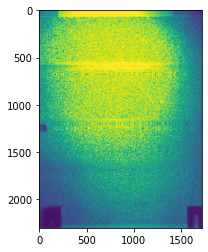

In [5]:
imshow(im3)

In [6]:
# %load Parameters.py

# function [Mconversion,Const,Lx,Lz,val_up,val_down,nx_pixel,ny_pixel,overlap_x,overlap_y]=Parameters(varargin)
# #  PARAMETERS_FILE


M=0.0123               #  From the calibration body: pixel/cm

# (see the numbers in the BOS sketch)
B=0*(1/M)              #  Distance section 5-6  
W=20*(1/M)             #  Distance section 3-4
L=110*(1/M)            #  Distance section 1-2
t=0.5*(1/M)            #  thickness of the glass
ZD=(L+2*t+W+B)*(1/M)    

#  Set the indexes of refraction
n_air=1                 
n_water=1.332 
n_glass=1.43 

#  Computing the constant 
Const_inv=2*(((L**2+B**2)/(n_air)) + (t**2/n_glass) + ((W)/(n_water))) 
Const=(Const_inv)**-1 

#  Dirichlet's conditions at the top and bottom
val_up=1.332     
val_down=1.433   #  

#  size of the images
Lx=1720  #  IN PIXEL 
Lz=2304 

Mconversion=M  

#  PIV-parameters
nx_pixel = 64 
ny_pixel = 64 
overlap_x = 0.5 
overlap_y = 0.5 


                                              
## CREATE THE CALIBRATION FIELD

### Correlation air-water

The calibration is the displacement field $\Delta x$; $\Delta y$
obtained correlating the air and water images (im1,im2).


In [ ]:

from BOS_correlation_OpenPIV import BOS_correlation_OpenPIV

Calibration = BOS_correlation_OpenPIV(im1,im2,nx_pixel,ny_pixel,overlap_x)
Magn_cal = sqrt(Calibration['u']**2 + Calibration['v']**2)


## THE REMAPPING 

Background pattern image obtained through the saline stratified solution
is remapped using the displacement field which origins are in the optical
system and aberrations due to the multi-media (air-glass-water-glass-air)
imaging


In [ ]:

[im3_remapped] = BOS_Remapping(Calibration,im3);   
imwrite(im3_remapped,'Remapped_4layers.tif')


In [ ]:

%% CORRELATION REFERENCE-REMAPPED
% The corrected image (im3_remapped) is correlated with the original 
% reference image takein in air (im1) and the result is used to construct
% the Poission equation and to solve it.
% We suggest to modify size of the An and overlap for a better
% cross-correlation result since the displacement im1-im3_remapped is one 
% order of magnitude smaller than im1-im2 displ.


In [ ]:

nx_pixel=32;
ny_pixel=32;
overlap_x=0.25;
skip = 5;              % Skip vectors


[Displacement_POisson]=BOS_correlation_OpenPIV(im1,im3_remapped,nx_pixel,...
    ny_pixel,overlap_x);

%% Comparison between corrected and not-corrected case
[Displ_notcorr]=BOS_correlation_OpenPIV(im2,im3,nx_pixel,ny_pixel,...
    overlap_x);



In [ ]:

figure
subplot(121)
quiver(Displ_notcorr.x(1:skip:end,1:skip:end),Displ_notcorr.y(1:skip:end,1:skip:end),...
    Displ_notcorr.u(1:skip:end,1:skip:end),Displ_notcorr.v(1:skip:end,1:skip:end),5);
axis equal
xlim([min(min(Displ_notcorr.x)),max(max(Displ_notcorr.x))])
ylim([min(min(Displ_notcorr.y)),max(max(Displ_notcorr.y))])
title('Displacement field without correction')
set(gca,'Ydir','reverse')
subplot(122)
quiver(Displacement_POisson.x(1:skip:end,1:skip:end),Displacement_POisson.y(1:skip:end,1:skip:end),...
    Displacement_POisson.u(1:skip:end,1:skip:end),Displacement_POisson.v(1:skip:end,1:skip:end),5);
axis equal
xlabel('x [px]')
ylabel('y [px]')
xlim([min(min(Displacement_POisson.x)),max(max(Displacement_POisson.x))])
ylim([min(min(Displacement_POisson.y)),max(max(Displacement_POisson.y))])
set(gca,'Ydir','reverse')
title('Displacement field corrected')



In [ ]:

%% POISSON INTEGRATION
% The result of the correlation (im1,im3_remapped) is than integrate
% through a Poisson's solutor. Eventually by applying the Gladstone-Dale 
% conversion we have computed the 2D density field.


In [ ]:

[n2, xc, zc]=BOS_PoissonSolver(Displacement_POisson,Const,Lx,Lz);
[n2_nc, x_nc, z_nc]=BOS_PoissonSolver(Displ_notcorr,Const,Lx,Lz);

% Gladstone-Dale conversion
[Dens,Dens_av]=Gladstone_Dale(n2,xc,zc);
[Dens_2,Dens_av_2]=Gladstone_Dale(n2_nc, x_nc, z_nc);


In [ ]:

%% GRAPHICAL OUTPUT 

% ++++++++++++ Comparison Magnitudo +++++++++++++++++++++++++++++++++++++++

Magnitudo=sqrt(Displacement_POisson.u.^2+Displacement_POisson.v.^2);
Magnitudo_nc=sqrt(Displ_notcorr.u.^2+Displ_notcorr.v.^2);

figure
subplot(121)
contourf(Displacement_POisson.x*Mconversion,...
    Displacement_POisson.y*Mconversion,Magnitudo,50)
axis equal
h1=colorbar;
xlabel('x [cm]')
ylabel('y [cm]')
axis equal
xlim([min(min(Displacement_POisson.x*Mconversion)),...
    max(max(Displacement_POisson.x*Mconversion))])
ylim([min(min(Displacement_POisson.y*Mconversion)),...
    max(max(Displacement_POisson.y*Mconversion))])
%caxis([0 5])
title('Corrected')
set(gca,'Ydir','reverse')
ylabel(h1,'$\sqrt{\Delta x^{2} +\Delta y^{2}} \hspace{0.25cm}[px]$');

subplot(122)
contourf(Displ_notcorr.x*Mconversion,Displ_notcorr.y*Mconversion,...
    Magnitudo_nc,50)
axis equal
h2=colorbar;
xlabel('x [cm]')
ylabel('y [cm]')
axis equal
xlim([min(min(Displ_notcorr.x*Mconversion)),...
    max(max(Displ_notcorr.x*Mconversion))])
ylim([min(min(Displ_notcorr.y*Mconversion)),...
    max(max(Displ_notcorr.y*Mconversion))])
%caxis([0 5])
title('Not-corrected')
set(gca,'Ydir','reverse')
ylabel(h2,'$\sqrt{\Delta x^{2} +\Delta y^{2}} \hspace{0.25cm}[px]$');


In [ ]:

% ++++ Results: Corrected Magnitude, Density field, Density profiles ++++++

figure
subplot('position',[0.08 0.35 0.3 0.4]);  
contour(Displacement_POisson.x*Mconversion,...
    Displacement_POisson.y*Mconversion,Magnitudo,20)
axis equal
h=colorbar;
xlabel('x [cm]')
ylabel('y [cm]')
xlim([min(min(Displacement_POisson.x*Mconversion)),...
    max(max(Displacement_POisson.x*Mconversion))])
ylim([min(min(Displacement_POisson.y*Mconversion)),...
    max(max(Displacement_POisson.y*Mconversion))])
% caxis([0 10])
title('Corrected')
set(gca,'Ydir','reverse')

subplot('position',[0.42 0.35 0.3 0.4]);  
pcolor(Dens.x*Mconversion, Dens.z*Mconversion, Dens.f')
shading flat
axis equal tight 
xlabel('x [cm]')
title('Density Corrected')
colorbar;
set(gca,'Ydir','reverse')

subplot('position',[0.77 0.4 0.20 0.45]); 
hold on
plot(Dens_av,Dens.z*Mconversion,'b','linewidth',1.5)
plot(Dens_av_2,Dens_2.z*Mconversion,'b--','linewidth',1.5)
xlabel('\rho [g/mL]')
xlim([0.99 1.3])
ylim([0 28])
Leg=legend('Corrected','Not-Corrected');
set(gca,'Ydir','reverse')
set(Leg,'location','northoutside');


In [ ]:

% ++++++++++++ Comparison POisson solutions +++++++++++++++++++++++++++++++

figure
subplot(121)
surf(xc,zc,n2')
xlabel('x [px]')
ylabel('y [px]')
zlabel('n')
title('Corrected')

subplot(122)
surf(x_nc,z_nc,n2_nc')
xlabel('x [px]')
ylabel('y [px]')
zlabel('n')
title('Not-corrected')


In [ ]:


%% ROUTINES
%% Parameters.m
% PARAMETERS_FILE

%  function [Mconversion,Const,Lx,Lz,val_up,val_down,nx_pixel,ny_pixel,...
%     overlap_x,overlap_y]=Parameters(varargin);

% Mconversion=0.0123;              % Using the calibration body: pixel/cm

% %(see the numbers in the BOS sketch)
% B=0*(1/Mconversion);             % Distance section 5-6  
% W=20*(1/Mconversion);            % Distance section 3-4
% L=110*(1/Mconversion);           % Distance section 1-2
% t=0.5*(1/Mconversion);           % thickness of the glass
% ZD=(L+2*t+W+B)*(1/Mconversion);   

% Set the indexes of refraction
% n_air=1;                
% n_water=1.332;
% n_glass=1.43;
 
% Compute the constant of the Poisson equation
% Const_inv=2*(((L^2+B^2)/(n_air)) + (t^2/n_glass) + ((W)/(n_water)));
% Const=(Const_inv)^-1;
 
% Dirichlet's conditions at the top and bottom
% val_up=1.332;    
% val_down=1.433;  % 
 
% Size of the images
% Lx=1720; % IN PIXEL 
% Lz=2304; 
 
% PIV-parameters
% nx_pixel = 64;
% ny_pixel = 64;
% overlap_x=0.5;
% overlap_y=0.5;


%% BOS_correlation_OpenPIV.m
% cross-correlation of two images, using OpenPIV (www.openpiv.net)
% Inputs:
%   im1,im2 - images
% Outputs:
%   Displ - displacement field, dx,dy

% function [Displ]=BOS_correlation_OpenPIV(im1,im2,nx,ny,overlap_x);

% Add openpiv toolbox:
% addpath('./openpiv');

% Overlap in pixels
% overlap_px = nx*overlap_x;   % pix
% overlap_py = nx*overlap_x;   % pix

% Compute the cross-correlation using OpenPIV
% Note that openpiv also saves .VEC file in the image folder if you need
% it later
% loadvec([imfile1,'.vec']);

% [x,y,u,v] = openpiv( im1, im2, ...
%     nx, ny, ...
%     overlap_px, overlap_py);

% u(isnan(u)) = 0;
% v(isnan(v)) = 0;
% u = medfilt2(u, [3 3]);  % size of the window
% v = medfilt2(v, [3 3]);

% Displ.x = x;
% Displ.y = y; 
% Displ.u = u;
% Displ.v = v; 

%% BOS_Remapping.m
% remapping has two steps:
% 1. interpolate the dx,dy fields to each pixel
% 2. warp the image according to the interpolated dx,dy
% [m,n] = size(im1); % note that m is vertical, n is horizontal
% [X,Y] = meshgrid(0:n-1,0:m-1); 

% function [new_image] = BOS_Remapping(Displ,im1);

% IMAGE_REMAPPED = BOS_REMAPPING(CALIBRATION,MAGE)
% Remaps the second image according to the displacement values stored ...
% into the calibration field.

% vi = interp2(Displ.x',Displ.y',Displ.v',X,Y,'linear');
% ui = interp2(Displ.x',Displ.y',Displ.u',X,Y,'linear');

% Replace the NaN using zeros
% ui(isnan(ui)) = 0;
% vi(isnan(vi)) = 0;

% im1=flipud(im1);
% new_image = flipud(imwarp(im1,ui,vi,true)); 
 
%% BOS_PoissonSolver.m

% function [n2, xc, zc]=BOS_PoissonSolver(Displacement_POisson,Const,Lx,Lz);

% Crop the field because of the remapping algorithm
% [Displ]=crop_field(Displacement_POisson,Lx,Lz);

% If you decide do not to crop the field, uncomment this line
% and comment the function crop_field:

%Displ=Displacement_POisson; 

% Create the RHS of the POISSON equation by loading the Displ
% function [Rhs]=create_RHS(Displ);

% Rotate the RHS
% rhs=Const.*fliplr(Rhs);
% [Rx,Ry]=size(rhs);

% Create the grid
% function [xc zc dxb dxc dzc dzb Nx Nz]= CreateGrid(Lx, Lz,Rx,Ry);

% Poisson integration
% function [n2]=Poisson_equation_2D(Lx,Lz,Rhs,Const);

%% List of the subfunctions contained in BOS_PoissonSolver

% # crop_field.m
% # create_RHS.m
% # CreateGrid.m
% # Poisson_equation_2D.m

%% crop_field.m
% This function crops the displacement field since the remapping algorithm
% has created the external frames (lack in the data) due to the moving of 
% the pixels close to the boundary of the image. 

% function [Displ]=crop_field(Displacement_POisson,Lx,Lz);

% Displ=Displacement_POisson;
% Minimum=min(min(Displ.y));
% Displ.y=Displ.y-abs(Minimum);
% Magnitude=sqrt(Displ.u.^2+Displ.v.^2);
% [a,b]=size(Displ.x);

% Dxx=Lx/a;
% Dyy=Lz/b;
% nx_pixels_crop=700;  %250
% ny_pixels_crop=350;  %200
% Lx=Lx-nx_pixels_crop;
% Lz=Lz-ny_pixels_crop;
% % number of pixels to crop in the right and left sides of the image
% Dx_pixels=round(nx_pixels_crop/Dxx);   
% Dy_pixels=round(ny_pixels_crop/Dyy);  
% Displ.x=Displ.x(Dx_pixels:end-Dx_pixels,Dy_pixels:end-Dy_pixels);
% Displ.y=Displ.y(Dx_pixels:end-Dx_pixels,Dy_pixels:end-Dy_pixels);
% Displ.u=(Displ.u(Dx_pixels:end-Dx_pixels,Dy_pixels:end-Dy_pixels));
% Displ.v=(Displ.v(Dx_pixels:end-Dx_pixels,Dy_pixels:end-Dy_pixels));
% Magnitude_crop=sqrt(Displ.u.^2+Displ.v.^2);
% Displ;

%% create_RHS.m
% The function creates the RHS of the Poisson equation deriving the
% displacement components obtained correlating the reference with ...
% the corrected image (im1,im3_remapped). 

% function [Rhs,Nx,Nz]=create_RHS(Displ);
% u=Displ.u;
% w=Displ.v;
% x=Displ.x;
% z=Displ.y;

% [width,height]=size(u);
% Compute the central difference fields

% Preallocation for the variables du and dw;
% du=zeros(width-2,height-2);
% dw=zeros(width-2,height-2);

% for k=2:width-1
% for j=2:height-1    
%     du(k,j)=(u(k+1,j)-u(k-1,j))/2*(abs(x(2,2)-x(2,1)));
%     dw(k,j)=(w(k,j+1)-w(k,j-1))/2*(abs(z(1,1)-z(1,2)));
% end
% end

% Rhs=(du+dw);
% Rhs(isnan(Rhs)) = 0 ;
% [Nz,Nx]=size(Rhs);

%% CreateGrid.m
% The following function generates the grid where the Poisson eq.
% will be solved.

% function [xc zc dxb dxc dzc dzb Nx Nz]= CreateGrid(Lx, Lz,Rx,Ry);

% Nx=Rx-2;
% Nz=Ry-2;
% xi=linspace(0,Lx,Nx+1);
% xb = xi;
% dxc=ones(length(xi));
% dxb=ones(length(xi));
% xc=linspace(0,Lx,Nx+2);
% zi=linspace(0,Lz,Nz+1);
% zb = zi;
% zc=linspace(0,Lz,Nz+2);
% dzc=ones(length(zi));
% dzb=ones(length(zi));

%% Poisson_equation_2D.m
% Solving the 2-D Poisson equation by the Finite Difference
...Method. 
% Numerical scheme used is a second order central difference in space
...(5-point difference).
    
% function [n2]=Poisson_equation_2D(Lx,Lz,Rhs,Const);

% [Nx,Nz]=size(Rhs);

%Specifying parameters (check why It does not work if we change them)
% dx=Lx/(Nx-1);              %Width of space step(x)
% dy=Lz/(Nz-1);              %Width of space step(y)
% x=0:dx:Lx;                 %Range of x(0,2) and specifying the grid points
% y=0:dy:Lz;                 %Range of y(0,2) and specifying the grid points
% b=zeros(Nx,Nz);            %Preallocating b
% pn=zeros(Nx,Nz);           %Preallocating pn

% Initial Conditions
% p=zeros(Nx,Nz);            %Preallocating p
% Rhs=Const.*fliplr(Rhs);   
% b=(Rhs);
% i=2:Nx-1;
% j=2:Nz-1;

% Poisson equation solution (iterative) method
% tol = 1e-4;			       % Set tollerance
% maxerr = inf;	               % initial error
% iter = 0;
% pn=p;
% 
% while maxerr > tol
%     iter = iter + 1;
%     disp(['Iteration no. ',num2str(iter)]);

%Explicit iterative scheme with C.D in space (5-point difference)
%     p(i,j)=((dy^2*(pn(i+1,j)+pn(i-1,j)))+(dx^2*(pn(i,j+1)+...
%         pn(i,j-1)))-(b(i,j)*dx^2*dy*2))/(2*(dx^2+dy^2));
 
% Boundary conditions     
% Neumann's conditions   % dp/dx|end=dp/dx|end-1 
%     p(1,:)=p(2,:);
%     p(end,:)=p(end-1,:);
       
% Neumann's conditions
%     p(:,1)=p(:,2);
%     p(:,end)=p(:,end-1);

%     maxerr = max(max(abs((p-pn)./p)));
%     disp(['Maximum error is  ',num2str(maxerr)]);
%     pn=p;

% end			% as long the error larger than tolerance, continue
% PG2_gray=p*255;
% n_max=1.43;    
% n_min=1.332;
% n2= scaledata(PG2_gray,n_min,n_max);

%% Gladstone_Dale.m
% The function converts the refractive index into density using the
% Gladstone Dale equation. 
% Galdstone-Dale constant for saline-water can be found in Google books:
% https://goo.gl/lIwuaL


% function [Dens,Dens_av]=Gladstone_Dale(n2,xc,zc);

% G=0.335;  %[g/mL]
% S_out=(n2-1)./G;
% Dens.x=xc;
% Dens.z=zc;
% Dens.f=S_out;
% Dens_av=mean((S_out));